
- does lspi work?
    - linear yes...
    - rbf no...
- how does linear lspi behave according to D? 
    - only optimal - yes
    - noisy optimal - yes
    - completely random - no

- dimensionality

- how does rbf lspi behave according to D? 
    - only optimal 
    - noisy optimal
    - completely random

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3

from logger import *
setup_logging(default_level=logging.INFO)


In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [10]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = get_linear_basis()
psi_linear = phi_linear

n_component = 7
p_rbf = n_component * 4 + 1
q_rbf = n_component * 4 + 1
phi_rbf = get_rbf_basis(env, n_component=n_component)
psi_rbf = phi_rbf

phi = phi_linear
p = p_linear

precision = 1e-8
eps = 1e-3
gamma = 0.99
action_list = range(env.action_space.n)

In [11]:
# one reason: basis function includes action (remove... but how?)
# swapping with the original code copy paste
# estimator update?
mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      action_list=action_list,
                      n_episode=70,
                      epsilon=0.0,
                      epsilon_decay=1.0,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve()
#plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)


/home/dhfromkorea/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 175 @ Episode 10/70 (-200.0)

KeyboardInterrupt: 

In [5]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi_near = NearExpertPolicy()
pi_random = RandomPolicy2(action_list)
#D, stats = sim.simulate(pi=pi_expert, n_trial=1, n_episode=100, return_stats=True)

pi_list = [pi_random, pi_near]
mix_ratio = [0.3, 0.7]
sample_size = 150
D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)

Step 150 @ Episode 105/105 (-157.0)

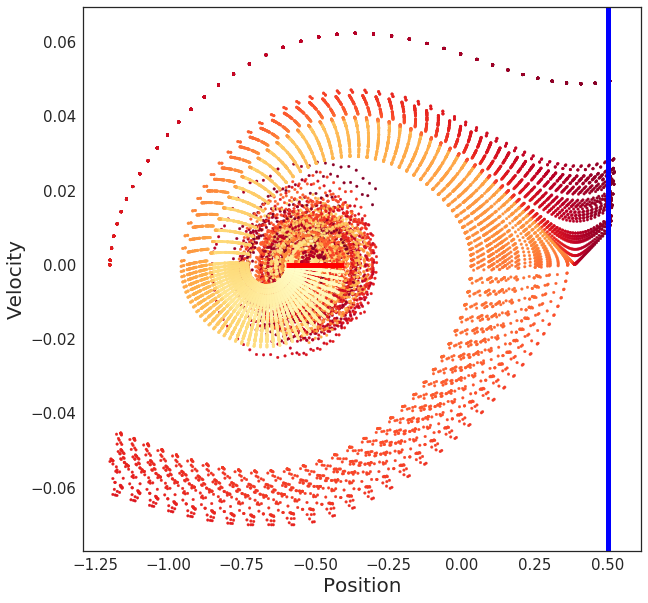

In [6]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrix)
plot_trajectory_mountain_car(D)

In [7]:
def solve_mountain_car_linear(p, phi, gamma, precision, eps, D):
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W
    
def solve_mountain_car_rbf(p, phi, gamma, precision, eps, D):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W

D_mat = Simulator.to_matrix(D)

In [8]:
D_mat[:, 2].max()


100

In [ ]:
print("batch data size {}".format(np.array(D_mat).shape))
#W_linear = solve_mountain_car_linear(p_linear, phi_linear, gamma, precision, eps, D_mat)
W_rbf = solve_mountain_car_rbf(p_rbf, phi_rbf, gamma, precision, eps, D_mat)

batch data size (22923, 5)


INFO:root:fitting D of the dimension:
(22923, 5)
/home/dhfromkorea/.local/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
INFO:root:lspi norm 1459.554998187373


hai ho
cond a_hat 465205.57235166145
Step 0 @ norm 1459.554998187373

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 61904.987202347045


hai ho
cond a_hat 6577312.269259436
Step 1 @ norm 61904.987202347045

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 37038.70222401237


hai ho
cond a_hat 4732795.225267215
Step 2 @ norm 37038.70222401237

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 65278.98779841526


hai ho
cond a_hat 196200.2068409276
Step 3 @ norm 65278.98779841526

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 139097.47034653582


hai ho
cond a_hat 1638714.0111033702
Step 4 @ norm 139097.47034653582

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 133548.3482487124


hai ho
cond a_hat 207327.71089163705
Step 5 @ norm 133548.3482487124

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 49029.15996296654


hai ho
cond a_hat 5383137.755881906
Step 6 @ norm 49029.15996296654

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 44150.69474169625


hai ho
cond a_hat 275295.2151175063
Step 7 @ norm 44150.69474169625

INFO:root:fitting D of the dimension:
(22923, 5)
INFO:root:lspi norm 84648.95509662066


hai ho
cond a_hat 805392.0281941068
Step 8 @ norm 84648.95509662066

In [ ]:
pi_star = LinearQ2(action_list=action_list, phi=phi_rbf, W=W_rbf)
#pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
plot_trajectory_mountain_car(D_star)